# Simple Convolutional Encoder Decoder
-  dataset: MNIST
- TensorFlow: tf.keras, tf.Estimator
- Colab TensorBoard monitoring

ToDo:
- rearrange encoder/decoder scopes
- move reshape out of model_fn

In [0]:
from datetime import datetime
import os
import tensorflow as tf
import numpy as np

## Define plotting utils

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]

def print_images(images, labels=None, images_per_row=5, title_prefix=''):
  
  n_images = len(images) 
  rows = (n_images + images_per_row -1) //images_per_row
  
  if labels is None:
    labels = n_images * ['']
    
  for idx, (image, label) in enumerate(zip(images, labels)):
    ax = plt.subplot(rows, images_per_row, idx+1)
    ax.imshow(np.squeeze(image))
    ax.axis('off')
    ax.set_title('{}{}'.format(title_prefix,label))

## Create LOGDIR folder

In [3]:
now = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
MODEL_DIR=os.path.join("/tmp/mnist_convnet_model", now)

try:  
    os.makedirs(MODEL_DIR)
except OSError:  
    print ("Creation of the directory %s failed" % MODEL_DIR)
else:  
    print ("Successfully created the directory %s " % MODEL_DIR)

Successfully created the directory /tmp/mnist_convnet_model/20190511_090410 


## Start TensorBoard

In [0]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(MODEL_DIR)
)

##[optional] Get ngrock and run it


In [5]:
import requests, time

max_tries=3  # max attempts
grace_time=1 # seconds

![[ ! -f "ngrok" ]]  \
  && wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip \
  && unzip ngrok-stable-linux-amd64.zip \
  && rm ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 6006 &')
time.sleep(grace_time)

for attempt in range(max_tries):
  try:
    tunnels_list = requests.get('http://localhost:4040/api/tunnels').json()['tunnels']
    print('resource available at: {}'.format(tunnels_list[0]['public_url']))
    break
    
  except ConnectionRefusedError:
    print('retry after {} second[s]'.format(grace_time))
    time.sleep(grace_time)  

--2019-05-11 09:04:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.84.112, 52.202.60.111, 34.196.237.103, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.84.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529980 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.76M  15.5MB/s    in 1.0s    

2019-05-11 09:04:12 (15.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16529980/16529980]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
resource available at: https://34094908.ngrok.io


# Define Estimator functions

In [0]:
def net_summary(net):
    for idx, t in enumerate(net):
      print('{} {} {}'.format(idx+1, t.name, t.shape))

In [0]:
def make_model_fn(optimizer, encoder_config, decoder_config):
  
  def _add_fc(net, config):
    for hidden in config:
      with tf.variable_scope('dense'):
        net.append(tf.keras.layers.Dense(hidden, 
                                         activation='relu', 
                                         name='fc')(net[-1]))
    return net
  
  def _add_encoder(net, config):
    with tf.variable_scope('encoder'):
      for cc in config:
        with tf.variable_scope('conv_pool'):
          [k, s, f] = cc['conv']
          activation = cc['activation']
        
          net.append(tf.keras.layers.Conv2D(filters=f, kernel_size=(k, k),
                                            padding='same',
                                            name='conv')(net[-1]))
        
          net.append(tf.keras.layers.MaxPooling2D((s, s), padding='same',
                                                  name='pool')(net[-1]))
    
    return net
  
  def _add_decoder(net, config):
    with tf.variable_scope('decoder'):
      for cc in config:
        with tf.variable_scope('conv_upsample'):
          [k, s, f] = cc['conv']
          activation = cc['activation']
        
          net.append(tf.keras.layers.Conv2D(filters=f, kernel_size=(k, k),
                                            padding='same',
                                            name='conv')(net[-1]))
        
          net.append(tf.keras.layers.UpSampling2D((s, s), name='upsample')(net[-1]))
    
    return net
    
  def _model_fn(features, labels, mode, params=None):
    """Model function for CNN."""
    
    net = []
    
    # Input Layer
    net.append(features["x"])
    #net.append(tf.keras.layers.Reshape([HEIGHT, WIDTH, CHANNELS], name='input')
    #           (features['x']))

    # encoder
    net = _add_encoder(net, encoder_config)
    encoded_image_shape=net[-1].shape.as_list()
    
    # Embeddings
    net.append(tf.keras.layers.Flatten(name='embeddings')(net[-1]))
    embeddings = net[-1]
    
    net.append(tf.keras.layers.Reshape(encoded_image_shape[1:])(net[-1]))
    
    # decoder
    net = _add_decoder(net, decoder_config)
    
    CHANNELS = features['x'].shape[-1].value
    net.append(tf.keras.layers.Conv2D(filters=CHANNELS, kernel_size=(3, 3),
                                      padding='same',activation='sigmoid',
                                      name='reconstructed')(net[-1]))
    
    # Dropout layer (on train graph)
    #if (mode == tf.estimator.ModeKeys.TRAIN):
    #  net.append(tf.keras.layers.Dropout(rate=0.4)(net[-1]))
    
    net_summary(net)
    
    # Compute predictions
    reconstructed_images = net[-1]
    
    predictions = {
        'embeddings': embeddings,
        'reconstructed_images': reconstructed_images
    }
    
    ###########
    # PREDICT #
    ###########
    if mode == tf.estimator.ModeKeys.PREDICT:
      return tf.estimator.EstimatorSpec(mode=mode,
                                        predictions=predictions)

    # Loss
    loss = tf.reduce_mean(tf.square(reconstructed_images-labels['y']))

    
    # Metrics
    mae = tf.metrics.mean_absolute_error(labels['y'], reconstructed_images,
                                         name='mae_op')
    
    metrics = {'mae': mae}
    tf.summary.scalar('mae', mae[1])
    
    ########
    # EVAL #
    ########
    if mode == tf.estimator.ModeKeys.EVAL:
      return tf.estimator.EstimatorSpec(mode, loss=loss,
                                        eval_metric_ops=metrics)
    
    #########
    # TRAIN #
    #########
    assert mode == tf.estimator.ModeKeys.TRAIN
    
    train_op = optimizer.minimize(loss, 
                                  global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op,
                                     eval_metric_ops=metrics)
  
  return _model_fn

In [0]:
def make_train_input_fn(features,
                        labels,
                        batch_size=100,
                        num_epochs=None,
                        shuffle=False):
    
  train_input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': features},
                                                      y={'y': labels},
                                                      batch_size=batch_size,
                                                      num_epochs=num_epochs,
                                                      shuffle=shuffle)
  return train_input_fn

def make_eval_input_fn(features,
                       labels=None):
  if labels is None:
    y = None
  else:
    y = {'y': labels}    
  eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': features},
                                                     y=y,
                                                     num_epochs=1,
                                                     shuffle=False)
  
  return eval_input_fn

# Load Dataset

In [0]:
# Load training and eval data
((train_data, train_classes),
 (eval_data, eval_classes)) = tf.keras.datasets.mnist.load_data()

train_data = train_data/np.float32(255)
train_classes = train_classes.astype(np.int32)  # not required

eval_data = eval_data/np.float32(255)
eval_classes = eval_classes.astype(np.int32)  # not required

# reshape to [batch, height, width, channels]
train_data = np.expand_dims(train_data, -1)
eval_data = np.expand_dims(eval_data, -1)

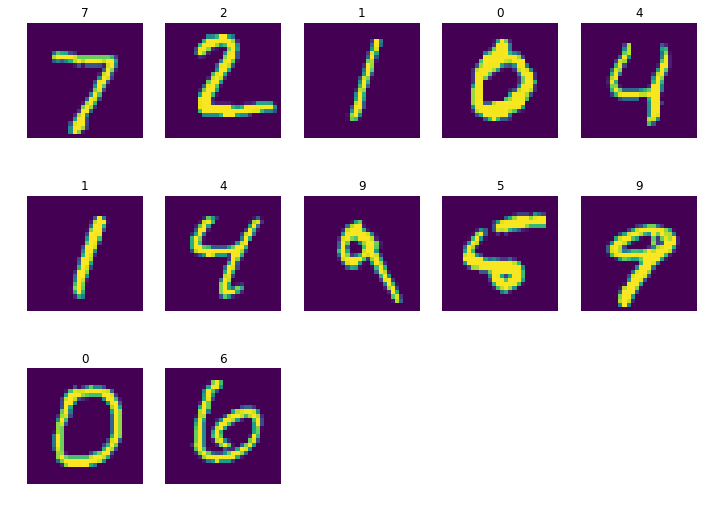

In [19]:
PICKED=12
print_images(eval_data[:PICKED], labels=eval_classes[:PICKED])

# Create the Estimator

In [0]:
learning_rate=0.1
batch_size=256
max_steps=20000

"""
encoder_config = [ {'conv': [5, 2, 32], 'activation': 'relu'},
                   {'conv': [5, 2, 64], 'activation': 'relu'}]
"""

encoder_config = [ {'conv':  [3, 2, 16], 'activation': 'relu'},
                   {'conv':  [3, 1, 16], 'activation': 'relu'},
                   {'conv':  [3, 2, 32], 'activation': 'relu'},
                   {'conv':  [3, 1, 32], 'activation': 'relu'},
                   {'conv':  [3, 1, 16], 'activation': 'relu'},
                   {'conv':  [3, 1, 8], 'activation': 'relu'},
                 ]

In [12]:
# Create the Estimator
my_checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 2000,
    #keep_checkpoint_max = 10,
    log_step_count_steps = 500,
    tf_random_seed=2020         # for reproducibility
)

train_spec = tf.estimator.TrainSpec(
    input_fn=make_train_input_fn(train_data,
                                 train_data,
                                 batch_size=batch_size),
    max_steps=max_steps)

eval_spec = tf.estimator.EvalSpec(
    input_fn=make_eval_input_fn(eval_data,
                                eval_data),
    steps=None,          # use complete eval set
    start_delay_secs=0,  # start immediately
    throttle_secs=10)    # minimum delay between evaluations

decoder_config = [ item for item in encoder_config[::-1] ]

optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
classifier = tf.estimator.Estimator(
  model_fn=make_model_fn(optimizer, encoder_config, decoder_config),
  model_dir=MODEL_DIR,
  config=my_checkpointing_config
)


INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_model/20190511_090410', '_tf_random_seed': 2020, '_save_summary_steps': 100, '_save_checkpoints_steps': 2000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdc608d6c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Start Training

In [13]:
tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 2000 or save_checkpoints_secs None.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
1 fifo_queue_DequeueMany:1 (256, 28, 28, 1)
2 encoder/conv_pool/conv/BiasAdd:0 (256, 28, 28, 16)
3 encoder/conv_pool/pool/MaxPool:0 (256, 14, 14, 16)
4 encoder/conv_pool_1/conv/BiasAdd:0 (256, 14, 14, 16)
5 encoder/conv_pool_1/pool/MaxPool:0 (256, 14, 14, 16)
6 encoder/conv_pool_2/conv/BiasAdd:0 (256, 14, 14, 32)
7 encoder/conv_pool_2/pool/MaxPool:0 (256, 7, 7, 32)
8 encoder/conv_

({'global_step': 20000, 'loss': 0.0034466519, 'mae': 0.019244103}, [])

# [optional] Stop Tensorboard

In [0]:
!pkill tensorboard && pkill ngrok

# Check reconstructed images

In [0]:
eval_subset = eval_data[:20]

y_pred = classifier.predict(input_fn=make_eval_input_fn(eval_subset))

In [36]:
rec_images = []
embeddings = []
for pred in y_pred:
  rec_images.append(pred['reconstructed_images'])
  embeddings.append(pred['embeddings'])

INFO:tensorflow:Calling model_fn.
1 fifo_queue_DequeueUpTo:1 (?, 28, 28, 1)
2 encoder/conv_pool/conv/BiasAdd:0 (?, 28, 28, 16)
3 encoder/conv_pool/pool/MaxPool:0 (?, 14, 14, 16)
4 encoder/conv_pool_1/conv/BiasAdd:0 (?, 14, 14, 16)
5 encoder/conv_pool_1/pool/MaxPool:0 (?, 14, 14, 16)
6 encoder/conv_pool_2/conv/BiasAdd:0 (?, 14, 14, 32)
7 encoder/conv_pool_2/pool/MaxPool:0 (?, 7, 7, 32)
8 encoder/conv_pool_3/conv/BiasAdd:0 (?, 7, 7, 32)
9 encoder/conv_pool_3/pool/MaxPool:0 (?, 7, 7, 32)
10 encoder/conv_pool_4/conv/BiasAdd:0 (?, 7, 7, 16)
11 encoder/conv_pool_4/pool/MaxPool:0 (?, 7, 7, 16)
12 encoder/conv_pool_5/conv/BiasAdd:0 (?, 7, 7, 8)
13 encoder/conv_pool_5/pool/MaxPool:0 (?, 7, 7, 8)
14 embeddings/Reshape:0 (?, 392)
15 reshape/Reshape:0 (?, 7, 7, 8)
16 decoder/conv_upsample/conv/BiasAdd:0 (?, 7, 7, 8)
17 decoder/conv_upsample/upsample/ResizeNearestNeighbor:0 (?, 7, 7, 8)
18 decoder/conv_upsample_1/conv/BiasAdd:0 (?, 7, 7, 16)
19 decoder/conv_upsample_1/upsample/ResizeNearestNeighbor

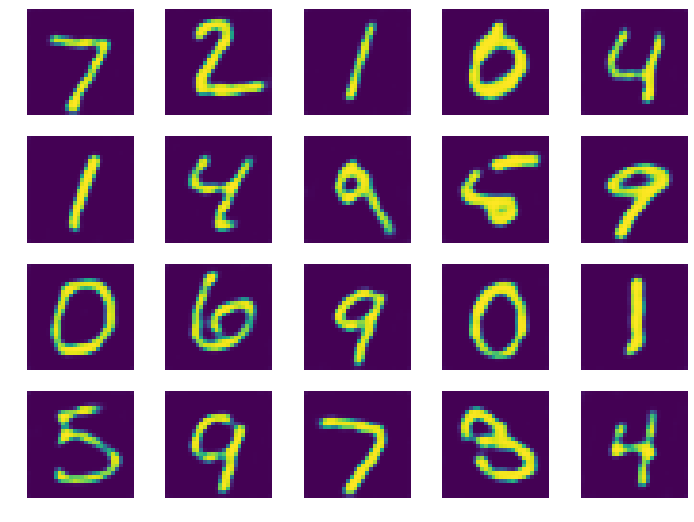

In [37]:
print_images(rec_images)

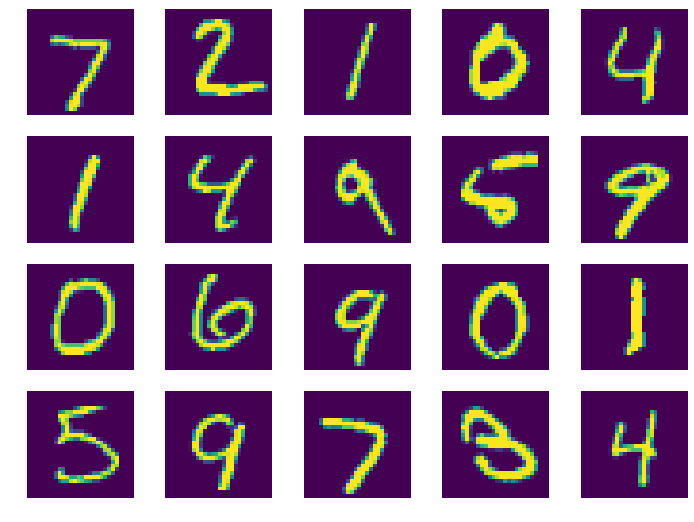

In [38]:
print_images(eval_subset)